In [5]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf

import logging 

logging.basicConfig(level=logging.WARN)
movieLocation = "../data/metacritic-movies/"
movieFull = pd.read_csv(os.path.join(movieLocation, "data_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI16 for _, movie in movieFull.iterrows()]

In [12]:
prediction = clf.predict_proba(rdf2vec_transformer._embeddings)
len(prediction)

x = list(map(lambda x: "good" if x[1] >= 0.5 else "bad", prediction))
ctr = 0
for i, it in enumerate(x):
    if i > 1800:
        if(it == movieFull.iloc[i].label):
            ctr += 1
ctr

ctr

192

In [13]:
192/200

0.96

In [11]:
with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
    clf = pickle.load(file)

with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)


In [35]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
    clf = pickle.load(file)

# TODO ! Check if entities in correct order
explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)


explained_entity_id = 92
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])


print("Explaining", explained_entity_uri)
print("Original prediction:", prediction, " / ".join(clf.classes_))
print("True class:", movieFull.iloc[explained_entity_id].label)

data, probabilities, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=50,
    num_samples=5000,
    allow_triple_addition=False,
    allow_triple_subtraction=True,
    max_changed_triples=20,
    change_count_fixed=True,
    use_w2v_freeze=True,
    center_correction=False,
    single_run=False,
    train_with_all=False,
    distance_metric="cosine",
    model_regressor=None,
    short_uris=False
)

# Albums: % modulo 10 = test
# Triple addition: Only try triples from n close neighbors (cosine)

Explaining http://dbpedia.org/resource/The_Matrix
Original prediction: [[0.08569592 0.91430408]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:10<00:00, 70.67it/s]


Average remaining walks per artificial entity (from 484): 458.3366


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [09:06<00:00,  9.15it/s]


Got data, labels, and distances


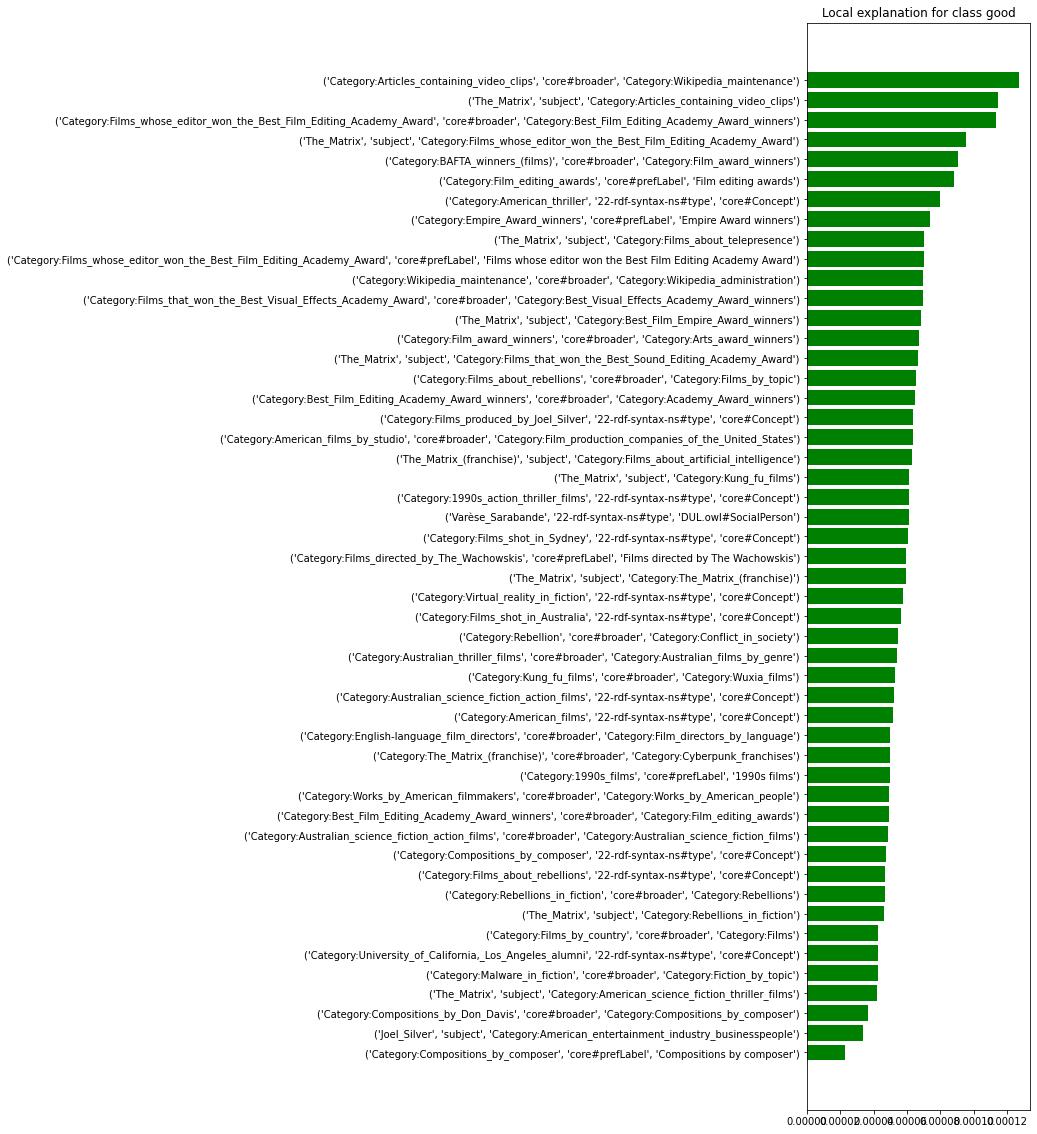

In [42]:
figsize = (4, .4*len(explanation.as_list()))

explanation.domain_mapper.short_uris=True
fig = explanation.as_pyplot_figure(figsize=figsize)
explanation.domain_mapper.short_uris=False


<AxesSubplot:>

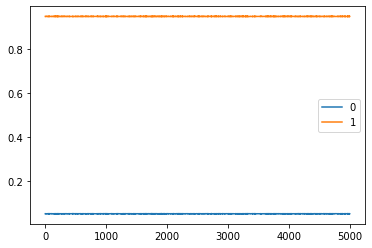

In [33]:
pd.DataFrame(probabilities).plot()

# thesis: show plot with/without single_run

In [ ]:
explanation.domain_mapper.short_uris=True
with open("test.html", "w") as f:
    f.write(explanation.as_html())
    explanation.domain_mapper.short_uris=False

In [36]:
iw = explainer.indexed_walks

top_triples = explanation.as_list()[:15]

relevant_walks = []
for triple in top_triples:
    for w in iw.walks(explained_entity_uri, tuple(triple[0])):
        
        entity_pos = w.index(explained_entity_uri)

        for i in range(2, len(w)):
            if w[i-2]== triple[0][0] and w[i-1] == triple[0][1] and w[i] == triple[0][2]:
                triple_start_pos = i-2
                triple_end_pos = i
        
        from_pos = min(entity_pos, triple_start_pos)
        to_pos = max(entity_pos, triple_end_pos)

        relevant_walks.append(w[from_pos:to_pos+1])



relevant_triples = iw.walks_as_triples(relevant_walks)

In [37]:
edges = []
labels = {}

min_edge_width = 0.25
max_edge_width = 8
max_score = max([abs(exp[1]) for exp in top_triples])

uri_trimmer = lambda uri: uri.split("/")[-1].split("#")[-1].replace(":", "_")
triple_trimmer = lambda triple: (uri_trimmer(triple[0]), uri_trimmer(triple[1]), uri_trimmer(triple[2]))

for rt in relevant_triples:
    score = next((exp[1] for exp in top_triples if rt==exp[0]), None)
    
    if score:
        # score *= -1
        color = "green" if score > 0 else "red"
        width = max(abs(score)/max_score*max_edge_width, min_edge_width)
    else:
        color = "blue"
        width = min_edge_width
        #print(rt, score)

    rt = triple_trimmer(rt)
    edge = (rt[0], rt[2], {"width": width, "color": color})
    
    label = rt[1]
    if score: label += f" ({round(width/max_edge_width, 2)})"

    edges.append(edge)
    
    labels[(edge[0],edge[1])] = label


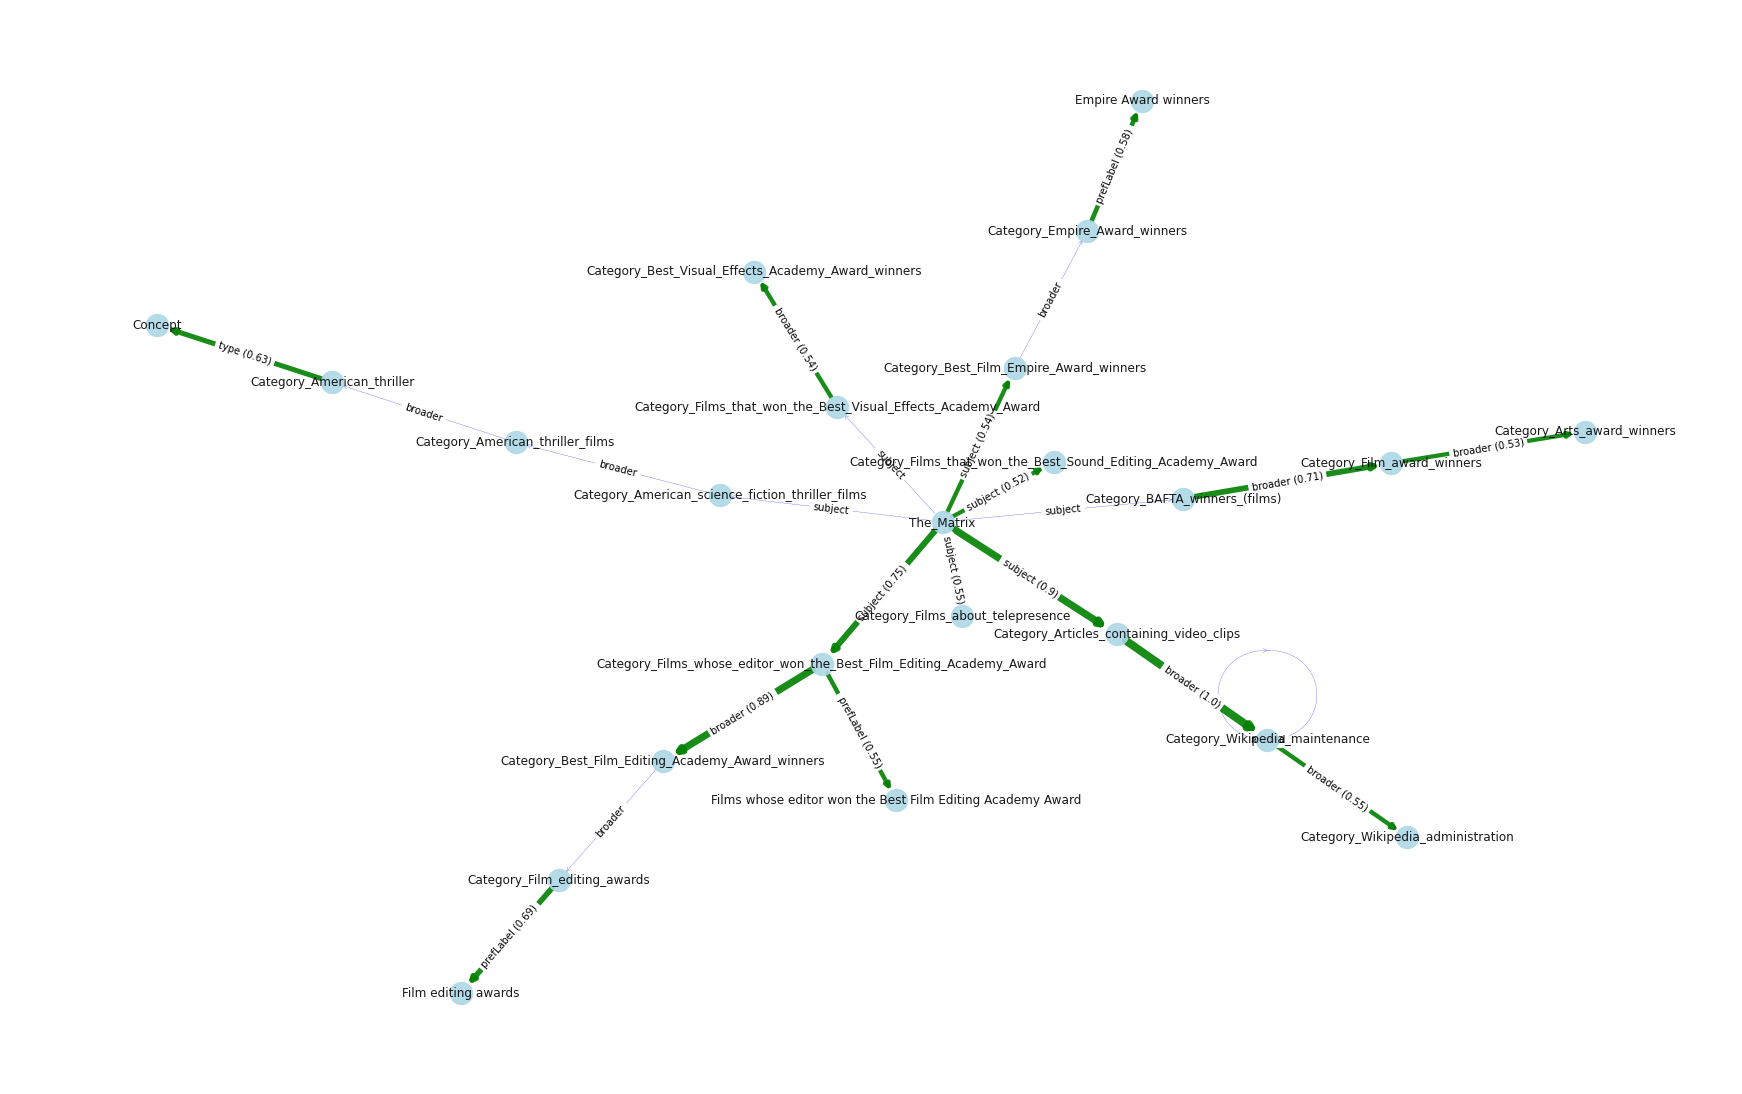

In [63]:
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

plt.figure(figsize=(24,15))

G = nx.DiGraph()
G.add_edges_from(edges)
# pos = nx.spring_layout(G, k=1.25/sqrt(len(G.nodes())), seed=42, iterations=35)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

nx.draw(
    G, pos,
    node_size=500, node_color='lightblue', alpha=0.9,
    labels={node: node for node in G.nodes()},
    arrowstyle='->',
    width=[G[u][v]['width'] for u,v in G.edges()],
    edge_color=[G[u][v]['color'] for u,v in G.edges()],
)


_ = nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black',
)

plt.savefig("test.svg")

In [65]:
from bokeh.io import output_file, save
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool, WheelZoomTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

# Prepare Data
"""
G = nx.karate_club_graph()

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")
""" 

# Show with Bokeh
plot = Plot(width=400, height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"
plot.width_policy="max"
plot.height_policy="max"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("club", "@club")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=10, fill_color=Spectral4[0])
#graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
save(plot)

'/workspaces/rdflime/rdflime-util/notebooks/interactive_graphs.html'

In [74]:
def check_explanations():
    exp_list = explanation.as_list()[:25]

    for exp in exp_list:
        triple = exp[0]
        if "_" in triple: continue
        modified_walks = explainer.get_perturbed_walks(explained_entity_uri, added_triples=[], removed_triples=[triple])
        embedding = explainer.get_perturbed_embedding(explained_entity_uri, modified_walks)
        new_prediction = clf.predict_proba([embedding])
        print( (new_prediction[0][1] - prediction[0][1]) / exp[1], triple )

In [ ]:
#
# Explained Change / Real Change
#
# +0.5 / +0.5 
# +
#


In [ ]:
check_explanations()

### Experiments

In [ ]:
from pyvis.network import Network
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show("nx.html")

In [ ]:
wv_old = explainer.old_transformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

In [ ]:
wv_old.most_similar(explainer.new_embeddings[150])

In [ ]:
# Check if the movie embedding itself drifted
all(embedding(explained_entity_uri, new=True) == embedding(explained_entity_uri, new=False))

In [ ]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=42).fit_transform([wv_old[explained_entity_uri]] + explainer.new_embeddings)

labels = explainer.old_transformer._entities + list(range(len(explainer.new_embeddings)))
labels = [explained_entity_uri] + list(range(len(explainer.new_embeddings)))

#colors = list(map(lambda e: "#00ff00" if movieTest[movieTest.DBpedia_URI==e].iloc[0].label == "good" else "#ff0000", transformer._entities[1600:]))
#sizes = list(map(lambda e: abs(50-movieTest[movieTest.DBpedia_URI==e].iloc[0].rating)**2, transformer._entities[1600:]))
sizes = list(map(lambda l: 100**2 if l == explained_entity_uri or l == 0 else 25**2, labels))

# Ploy the embeddings of entities in a 2D plane, annotating them.
f = plt.figure(figsize=(200, 80))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=sizes)#, c=colors, s=sizes)

for x, y, t in zip(X_tsne[:, 0], X_tsne[:, 1], labels):
    if type(t) == str and "http" in t: t = t.split("/")[-1]
    plt.annotate(t, (x, y))

# Display the graph with a title, removing the axes for better readability.
plt.title("pyRDF2Vec", fontsize=4)
plt.axis("off")
plt.show()

#f.savefig("figure.pdf", bbox_inches='tight')


In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples

In [ ]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[0]
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

In [33]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("matrix")

[(92, 'http://dbpedia.org/resource/The_Matrix'),
 (1154, 'http://dbpedia.org/resource/The_Matrix_Reloaded')]

In [34]:
movieFull[-200:]

,Wikidata_URI15,Movie,Release date,DBpedia_URI,label,id,rating,DBpedia_URI15,YAGO_URI15,DBpedia_URI15_Base32,DBpedia_URI16
1800,http://www.wikidata.org/entity/Q3196650,Killing Season,07/12/2013 00:00,http://dbpedia.org/resource/Killing_Season_(film),bad,1401,25,http://dbpedia.org/resource/Killing_Season_(film),http://yago-knowledge.org/resource/Killing_Sea...,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6S...,http://dbpedia.org/resource/Killing_Season_(film)
1801,http://www.wikidata.org/entity/Q2337365,Modigliani,5/13/2005 0:00,http://dbpedia.org/resource/Modigliani_(film),bad,1402,25,http://dbpedia.org/resource/Modigliani_(film),http://yago-knowledge.org/resource/Modigliani_...,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6T...,http://dbpedia.org/resource/Modigliani_(film)
1802,http://www.wikidata.org/entity/Q3012553,R.I.P.D.,7/19/2013 0:00,http://dbpedia.org/resource/R.I.P.D.,bad,1403,25,http://dbpedia.org/resource/R.I.P.D.,http://yago-knowledge.org/resource/R.I.P.D.,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6U...,http://dbpedia.org/resource/R.I.P.D.
1803,http://www.wikidata.org/entity/Q3283693,September Dawn,8/24/2007 0:00,http://dbpedia.org/resource/September_Dawn,bad,1404,25,http://dbpedia.org/resource/September_Dawn,http://yago-knowledge.org/resource/September_Dawn,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6U...,http://dbpedia.org/resource/September_Dawn
1804,http://www.wikidata.org/entity/Q7544696,Smiley,10/12/2012 00:00,http://dbpedia.org/resource/Smiley_(2012_film),bad,1405,25,http://dbpedia.org/resource/Smiley_(2012_film),NaN,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6U...,http://dbpedia.org/resource/Smiley_(2012_film)
...,...,...,...,...,...,...,...,...,...,...,...
1995,http://www.wikidata.org/entity/Q475136,Miss March,3/13/2009 0:00,http://dbpedia.org/resource/Miss_March,bad,1596,7,http://dbpedia.org/resource/Miss_March,http://yago-knowledge.org/resource/Miss_March,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6T...,http://dbpedia.org/resource/Miss_March
1996,http://www.wikidata.org/entity/Q1265063,Screwed,05/12/2000 00:00,http://dbpedia.org/resource/Screwed_(2000_film),bad,1597,7,http://dbpedia.org/resource/Screwed_(2000_film),NaN,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6U...,http://dbpedia.org/resource/Screwed_(2000_film)
1997,http://www.wikidata.org/entity/Q232248,Two of a Kind,12/16/1983 0:00,http://dbpedia.org/resource/Two_of_a_Kind_(198...,bad,1598,5,http://dbpedia.org/resource/Two_of_a_Kind_(198...,NaN,NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6V...,http://dbpedia.org/resource/Two_of_a_Kind_(198...
1998,http://www.wikidata.org/entity/Q7943531,Vulgar,4/26/2002 0:00,http://dbpedia.org/resource/Vulgar_(film),bad,1599,5,http://dbpedia.org/resource/Vulgar_(film),http://yago-knowledge.org/resource/Vulgar_(film),NB2HI4B2F4XWIYTQMVSGSYJON5ZGOL3SMVZW65LSMNSS6V...,http://dbpedia.org/resource/Vulgar_(film)


In [ ]:
from concurrent.futures import ProcessPoolExecutor

def xm(i): 
    print(i)

with ProcessPoolExecutor() as executor:
    executor.map(xm, [1,2,3])

In [ ]:
for i in range(155):

    reload(lime.lime_rdf)
    from lime.lime_rdf import LimeRdfExplainer

    with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
        rdf2vec_transformer = pickle.load(file)

    with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
        clf = pickle.load(file)

    explainer = LimeRdfExplainer(
        transformer=rdf2vec_transformer, 
        entities=movies,
        class_names=clf.classes_,
        kernel=None,
        kernel_width=25,
        verbose=False,
        feature_selection="auto",
        random_state=42
    )


    explained_entity_id = i  # 0-400 -> test data
    explained_entity_uri = movies[explained_entity_id]
    prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])


    print("Explaining", explained_entity_uri)
    print("Original prediction:", prediction, " / ".join(clf.classes_))
    print("True class:", movieFull.iloc[explained_entity_id].label)

    data, probabilities, distances, explanation = explainer.explain_instance(
        entity=explained_entity_uri, 
        classifier_fn=clf.predict_proba,
        num_features=50,
        num_samples=5000,
        allow_triple_addition=False,
        allow_triple_subtraction=True,
        max_changed_triples=20,
        change_count_fixed=True,
        use_w2v_freeze=True,
        center_correction=False,
        single_run=False,
        train_with_all=False,
        distance_metric="cosine",
        model_regressor=None,
        short_uris=False
    )

    with open(f"explanation-{i}", "wb") as f:
        pickle.dump([explanation, probabilities], f)